In [1]:
import pandas as pd
import numpy as np
import math
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from multiprocessing import Pool
seed = 42

In [2]:
with Pool(50) as p:
    samples = pd.concat(p.map(pd.read_csv, glob.glob('./outputs/ibm_net_series/*.csv')))
samples = samples.reset_index(drop=True)

In [3]:
samples = samples.drop(samples[samples.EIR == -1].index).reset_index(drop=True)

In [4]:
output_columns = [name for name in samples.columns if 'prev_' in name]
outputs = samples[output_columns]
year = [year for year in range(len(output_columns) // 365) for _ in range(365)]
outputs = outputs.groupby(by=year, axis=1).mean()
ts_columns = [name for name in samples.columns if 'itn_usage_' in name]
features = samples.drop(labels=output_columns + ts_columns + ['init_EIR'], axis=1)
ts_features = samples[ts_columns]
n_features = len(features.columns)
n_ts_features = len(ts_columns)
n_outputs = len(outputs.columns)

In [5]:
idx_train, idx_test = train_test_split(
    np.arange(len(outputs)), #np.arange(100000),
    test_size=0.2,
    random_state=seed
)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

2022-11-24 13:59:35.721993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 13:59:36.313140: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
X_train = features.iloc[idx_train]
X_seq_train = ts_features.iloc[idx_train].to_numpy()[:, :, np.newaxis]
y_train = outputs.iloc[idx_train].to_numpy()[:, :, np.newaxis]
X_test = features.iloc[idx_test]
X_seq_test = ts_features.iloc[idx_test].to_numpy()[:, :, np.newaxis]
y_test = outputs.iloc[idx_test].to_numpy()[:, :, np.newaxis]

scaler = layers.Normalization()
scaler.adapt(X_train.to_numpy())

2022-11-24 13:59:39.377200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 13:59:41.665237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38406 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2022-11-24 13:59:41.686907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38406 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [8]:
import tensorflow.keras.backend as K

class RepeatLayer(layers.Layer):

    def call(self, inputs):
        static, seq = inputs
        return tf.repeat(static[:, np.newaxis, :], K.shape(seq)[1], axis=1)

def create_sequence_model(
    optimiser='adam',
    n_hidden=2,
    units=128,
    dropout=0.,
    loss='log_cosh',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal',
    output_units=y_train.shape[2],
):
    input_layer = Input(shape=n_features, dtype='float32')
    seq_input = Input(shape=(None, 1), dtype='float32')
    static_input = scaler(input_layer)
    static_input_ts = static_input[:, np.newaxis, :]
    repeated_static_input = RepeatLayer()([static_input, seq_input])
    recurrent_output = layers.Concatenate()(
        [seq_input, repeated_static_input]
    )
    for i in range(n_hidden):
        recurrent_output = layers.LSTM(
            units,
            return_sequences=True
        )(recurrent_output)
    output = layers.TimeDistributed(
        layers.Dense(output_units, activation=output_activation, kernel_initializer=output_initialiser)
    )(recurrent_output)
    model = Model(inputs = [input_layer, seq_input], outputs = [output])
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [9]:
model = create_sequence_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 normalization (Normalization)  (None, 31)           63          ['input_1[0][0]']                
                                                                                                  
 repeat_layer (RepeatLayer)     (None, None, 31)     0           ['normalization[0][0]',          
                                                                  'input_2[0][0]']            

In [ ]:
model.fit((X_train, X_seq_train), y_train, batch_size=100, epochs=100)

Epoch 1/100


2022-11-24 13:59:52.332323: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2022-11-24 13:59:52.644817: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


441/441 [==============================] - 11s 11ms/step - loss: 0.0014 - mse: 0.0027
Epoch 2/100
441/441 [==============================] - 5s 11ms/step - loss: 3.4385e-04 - mse: 6.8842e-04
Epoch 3/100
 31/441 [=>............................] - ETA: 4s - loss: 2.6468e-04 - mse: 5.2977e-04

In [ ]:
y_hat = model.predict((X_test, X_seq_test))

In [ ]:
plt.scatter(y_hat.flatten(), y_test.flatten(), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

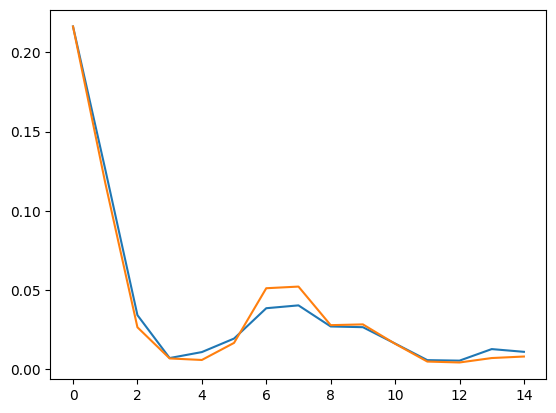

In [19]:
i = 100
plt.plot(range(15), y_hat[i,:,0])
plt.plot(range(15), y_test[i,:,0])

In [12]:
import keras_tuner as kt

In [13]:
def bulid_hypermodel(hp):
    return create_model(
        n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, step=1),
        units = hp.Int("units", min_value=32, max_value=512, step=32),
        dropout = hp.Float("dropout", min_value=0., max_value=.2, step=.01),
        loss = hp.Choice("loss", ['mse', 'log_cosh']),
        hidden_activation = hp.Choice("hidden_activation", ['relu', 'elu']),
        output_activation = hp.Choice("output_activation", ['linear', 'softmax'])
    )

In [14]:
tuner = kt.Hyperband(
    hypermodel=bulid_hypermodel,
    objective="val_mse",
    max_epochs=100,
    seed=42,
    overwrite=True,
    directory="hyperparameters",
    project_name="det",
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
n_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.01, 'sampling': None}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'log_cosh'], 'ordered': False}
hidden_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
output_activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax'], 'ordered': False}


In [16]:
X_hyp_train, X_hyp_val, y_hyp_train, y_hyp_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

In [17]:
tuner.search(
    X_hyp_train,
    y_hyp_train,
    validation_data=(X_hyp_val, y_hyp_val),
    callbacks=[tf.keras.callbacks.EarlyStopping("mse", min_delta=1e-10, patience=5)]
)

Trial 230 Complete [00h 02m 17s]
val_mse: 0.00022005359642207623

Best val_mse So Far: 9.33476330828853e-05
Total elapsed time: 02h 25m 44s

Search: Running Trial #231

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_hidden
192               |96                |units
0.02              |0                 |dropout
mse               |mse               |loss
elu               |elu               |hidden_activation
linear            |linear            |output_activation
34                |100               |tuner/epochs
12                |34                |tuner/initial_epoch
2                 |4                 |tuner/bracket
1                 |4                 |tuner/round
0225              |0144              |tuner/trial_id

Epoch 13/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 14/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0023 - 

KeyboardInterrupt: 

623/623 [==============================] - 1s 1ms/step


Text(0, 0.5, 'true')

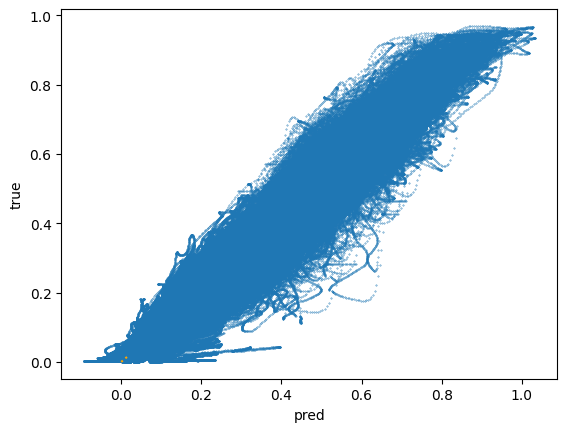

In [38]:
bm = tuner.get_best_models(num_models=1)[0]
y_hat = model.predict(X_test)
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.02), np.linspace(0, 0.02), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [39]:
tuner.results_summary()

Results summary
Results in hyperparameters/eq
Showing 10 best trials
Trial summary
Hyperparameters:
n_hidden: 4
units: 128
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.0011498170206323266
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.07
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 0.0012141329934820533
Trial summary
Hyperparameters:
n_hidden: 3
units: 192
dropout: 0.04
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0219
Score: 0.0015096659772098064
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch:

In [30]:
model.save('models/det_sequence')

INFO:tensorflow:Assets written to: models/det_sequence/assets


INFO:tensorflow:Assets written to: models/det_sequence/assets
